# Улучшение модели прогнозирования продаж (Improvements)

## 1: Импорт библиотек и настройка

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import datetime
import json, joblib
import os
from scipy import stats

# Настройки визуализации
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
warnings.filterwarnings('ignore')

# ML библиотеки
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, cross_validate, train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, make_scorer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.impute import SimpleImputer

# Модели
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor

print("Библиотеки загружены!")

Библиотеки загружены!


## 2: Пошаговое добавление фич


🎯 Эксперимент 0: Базовая модель
  Фолд 1... RMSE: 16031.5
  Фолд 2... RMSE: 14013.9
  Фолд 3... RMSE: 9747.7

🎯 Эксперимент 1: + month
  Фолд 1... RMSE: 15950.8
  Фолд 2... RMSE: 13983.3
  Фолд 3... RMSE: 9713.9

🎯 Эксперимент 2: + week_of_year
  Фолд 1... RMSE: 16073.3
  Фолд 2... RMSE: 13935.6
  Фолд 3... RMSE: 9633.3

🎯 Эксперимент 3: + quarter
  Фолд 1... RMSE: 16102.9
  Фолд 2... RMSE: 14055.1
  Фолд 3... RMSE: 9705.6

🎯 Эксперимент 4: + все временные
  Фолд 1... RMSE: 15994.5
  Фолд 2... RMSE: 13995.8
  Фолд 3... RMSE: 9619.9

📊 Сравнение всех экспериментов
    Эксперимент    rmse  rmse_std    mae  mae_std    r2  r2_std  Улучшение RMSE  Улучшение R²  % улучшения RMSE
       Baseline 13264.4    2619.6 7665.8   1763.7 0.626  0.0618             0.0        0.0000              0.00
        + month 13216.0    2603.4 7638.5   1760.1 0.629  0.0614            48.4        0.0027              0.36
 + week_of_year 13214.1    2678.1 7633.9   1793.5 0.630  0.0641            50.3        0.0031

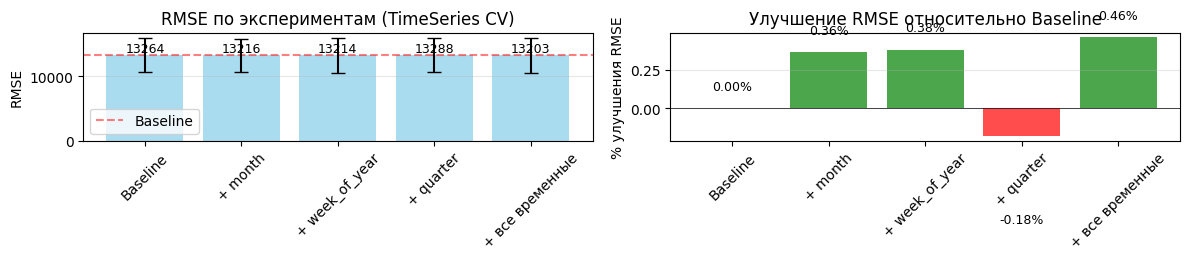


🏆 Обучение финальной модели на лучших признаках...
Лучший эксперимент: + все временные
Обучение финальной модели...

📊 Финальные метрики на тестовой выборке:
  RMSE: 12065.1
  MAE: 8386.8
  R²: 0.580
✓ Модель сохранена: ../reports/improvements/models/final_model__все_временные.pkl


In [ ]:
# Часть 1: Базовый пайплайн + пошаговое добавление фич

## 2: Загрузка данных
processed_data_path = '../data/processed/baseline_data.csv'
df = pd.read_csv(processed_data_path, parse_dates=['Date'])
target_col = 'Weekly_Sales'

# Базовый датасет (без временных признаков из даты)
df_basic = df.copy()
df_basic = df_basic.drop('Date', axis=1)

## 3: Функция для создания временных признаков БЕЗ УТЕЧЕК
def create_temporal_features_no_leakage(df_original, X_split, split_type='train'):
    """
    Создает временные признаки без утечек данных
    split_type: 'train' или 'test'
    """
    X_result = X_split.copy()
    
    # Для тестовой выборки используем только известную информацию
    if split_type == 'train':
        # Получаем соответствующие даты из оригинального датафрейма
        train_indices = X_split.index
        dates = df_original.loc[train_indices, 'Date'].copy()
    else:
        # Для теста мы не знаем будущих дат в реальном сценарии
        # Используем только порядковые признаки
        test_indices = X_split.index
        dates = df_original.loc[test_indices, 'Date'].copy()
    
    # Создаем признаки без утечек
    X_result['month'] = dates.dt.month
    
    # week_of_year - может быть сезонный паттерн
    X_result['week_of_year'] = dates.dt.isocalendar().week
    
    # quarter
    X_result['quarter'] = dates.dt.quarter
    
    # Бинарные признаки на основе месяца (без утечек)
    X_result['is_december'] = (X_result['month'] == 12).astype(int)
    X_result['is_summer'] = X_result['month'].isin([6, 7, 8]).astype(int)
    X_result['is_holiday_season'] = X_result['month'].isin([11, 12]).astype(int)
    
    # Признаки на основе недели
    X_result['is_week_48_52'] = X_result['week_of_year'].isin([48, 49, 50, 51, 52]).astype(int)
    X_result['is_week_1_4'] = X_result['week_of_year'].isin([1, 2, 3, 4]).astype(int)
    
    return X_result

## 4: Функция для оценки пайплайна с TimeSeriesSplit
def evaluate_pipeline_safe(X_full, y_full, feature_creator=None, 
                          pipeline_name="Baseline", n_splits=3):
    """Создает, обучает и оценивает пайплайн с временной валидацией"""
    
    tscv = TimeSeriesSplit(n_splits=n_splits, gap=1)  # gap=1 предотвращает перекрытие дат
    fold_results = []
    
    for fold, (train_idx, test_idx) in enumerate(tscv.split(X_full), 1):
        print(f"  Фолд {fold}...", end=" ")
        
        # Разделение данных
        X_train_raw = X_full.iloc[train_idx]
        X_test_raw = X_full.iloc[test_idx]
        y_train = y_full.iloc[train_idx]
        y_test = y_full.iloc[test_idx]
        
        # Создание признаков БЕЗ УТЕЧЕК
        if feature_creator:
            X_train = feature_creator(df, X_train_raw, split_type='train')
            X_test = feature_creator(df, X_test_raw, split_type='test')
        else:
            X_train = X_train_raw.copy()
            X_test = X_test_raw.copy()
        
        # Определение типов признаков
        numeric_features = []
        categorical_features = []
        
        for col in X_train.columns:
            if pd.api.types.is_numeric_dtype(X_train[col]):
                # Числовые с малым количеством уникальных значений -> категориальные
                if X_train[col].nunique() <= 15 and col not in ['month', 'week_of_year', 'quarter']:
                    categorical_features.append(col)
                    # Конвертируем в строку для корректной обработки
                    X_train[col] = X_train[col].astype(str)
                    X_test[col] = X_test[col].astype(str)
                else:
                    numeric_features.append(col)
            else:
                categorical_features.append(col)
        
        # Преобразуем категориальные в строки
        for col in categorical_features:
            if col in X_train.columns and col not in numeric_features:
                X_train[col] = X_train[col].astype(str)
                if col in X_test.columns:
                    X_test[col] = X_test[col].astype(str)
        
        # Создание пайплайна
        numeric_transformer = Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ])
        
        categorical_transformer = Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
            ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
        ])
        
        preprocessor = ColumnTransformer(
            transformers=[
                ('num', numeric_transformer, numeric_features),
                ('cat', categorical_transformer, categorical_features)
            ],
            remainder='drop'
        )
        
        pipeline = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('model', RandomForestRegressor(
                n_estimators=50,  # Уменьшено для скорости
                random_state=42,
                n_jobs=-1,
                max_depth=10,
                min_samples_split=10,
                max_samples=0.8  # Bagging для уменьшения переобучения
            ))
        ])
        
        # Обучение и предсказания
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)
        
        # Метрики
        fold_metrics = {
            'fold': fold,
            'rmse': np.sqrt(mean_squared_error(y_test, y_pred)),
            'mae': mean_absolute_error(y_test, y_pred),
            'r2': r2_score(y_test, y_pred)
        }
        
        fold_results.append(fold_metrics)
        print(f"RMSE: {fold_metrics['rmse']:.1f}")
    
    # Агрегируем результаты по фолдам
    rmse_values = [r['rmse'] for r in fold_results]
    mae_values = [r['mae'] for r in fold_results]
    r2_values = [r['r2'] for r in fold_results]
    
    return {
        'cv_rmse_mean': np.mean(rmse_values),
        'cv_rmse_std': np.std(rmse_values),
        'cv_mae_mean': np.mean(mae_values),
        'cv_mae_std': np.std(mae_values),
        'cv_r2_mean': np.mean(r2_values),
        'cv_r2_std': np.std(r2_values),
        'fold_results': fold_results
    }

## 5: БАЗОВАЯ МОДЕЛЬ (без временных признаков)
print("\n🎯 Эксперимент 0: Базовая модель")
X_basic = df_basic.drop(columns=[target_col])
y_basic = df_basic[target_col]
baseline_results = evaluate_pipeline_safe(X_basic, y_basic, pipeline_name="Baseline")

## 6: Эксперименты с добавлением признаков (БЕЗ day_of_week)
experiments_results = {}

# Функция-создатель признаков для каждого эксперимента
def create_exp1_features(df_original, X_split, split_type='train'):
    """Только месяц"""
    X_result = X_split.copy()
    if split_type == 'train':
        dates = df_original.loc[X_split.index, 'Date'].copy()
    else:
        dates = df_original.loc[X_split.index, 'Date'].copy()
    X_result['month'] = dates.dt.month
    return X_result

def create_exp2_features(df_original, X_split, split_type='train'):
    """Месяц + неделя года"""
    X_result = create_exp1_features(df_original, X_split, split_type)
    if split_type == 'train':
        dates = df_original.loc[X_split.index, 'Date'].copy()
    else:
        dates = df_original.loc[X_split.index, 'Date'].copy()
    X_result['week_of_year'] = dates.dt.isocalendar().week
    return X_result

def create_exp3_features(df_original, X_split, split_type='train'):
    """Месяц + неделя + квартал"""
    X_result = create_exp2_features(df_original, X_split, split_type)
    if split_type == 'train':
        dates = df_original.loc[X_split.index, 'Date'].copy()
    else:
        dates = df_original.loc[X_split.index, 'Date'].copy()
    X_result['quarter'] = dates.dt.quarter
    return X_result

def create_exp4_features(df_original, X_split, split_type='train'):
    """Все временные + бинарные признаки"""
    X_result = create_exp3_features(df_original, X_split, split_type)
    
    # Бинарные признаки
    X_result['is_december'] = (X_result['month'] == 12).astype(int)
    X_result['is_summer'] = X_result['month'].isin([6, 7, 8]).astype(int)
    X_result['is_holiday_season'] = X_result['month'].isin([11, 12]).astype(int)
    X_result['is_week_48_52'] = X_result['week_of_year'].isin([48, 49, 50, 51, 52]).astype(int)
    X_result['is_week_1_4'] = X_result['week_of_year'].isin([1, 2, 3, 4]).astype(int)
    X_result['is_quarter_end'] = X_result['month'].isin([3, 6, 9, 12]).astype(int)
    
    return X_result

# Эксперимент 1: + month
print("\n🎯 Эксперимент 1: + month")
experiments_results['+ month'] = evaluate_pipeline_safe(
    X_basic, y_basic, 
    feature_creator=create_exp1_features,
    pipeline_name="month"
)

# Эксперимент 2: + week_of_year
print("\n🎯 Эксперимент 2: + week_of_year")
experiments_results['+ week_of_year'] = evaluate_pipeline_safe(
    X_basic, y_basic,
    feature_creator=create_exp2_features,
    pipeline_name="week_of_year"
)

# Эксперимент 3: + quarter
print("\n🎯 Эксперимент 3: + quarter")
experiments_results['+ quarter'] = evaluate_pipeline_safe(
    X_basic, y_basic,
    feature_creator=create_exp3_features,
    pipeline_name="quarter"
)

# Эксперимент 4: + все временные
print("\n🎯 Эксперимент 4: + все временные")
experiments_results['+ все временные'] = evaluate_pipeline_safe(
    X_basic, y_basic,
    feature_creator=create_exp4_features,
    pipeline_name="all_temporal"
)

## 7: Сравнение результатов
print("\n📊 Сравнение всех экспериментов")
print("=" * 60)

# Собираем все результаты
comparison_data = []

# Baseline
comparison_data.append({
    'Эксперимент': 'Baseline',
    'rmse': baseline_results['cv_rmse_mean'],
    'rmse_std': baseline_results['cv_rmse_std'],
    'mae': baseline_results['cv_mae_mean'],
    'mae_std': baseline_results['cv_mae_std'],
    'r2': baseline_results['cv_r2_mean'],
    'r2_std': baseline_results['cv_r2_std']
})

# Эксперименты
for exp_name, results in experiments_results.items():
    comparison_data.append({
        'Эксперимент': exp_name,
        'rmse': results['cv_rmse_mean'],
        'rmse_std': results['cv_rmse_std'],
        'mae': results['cv_mae_mean'],
        'mae_std': results['cv_mae_std'],
        'r2': results['cv_r2_mean'],
        'r2_std': results['cv_r2_std']
    })

comparison_df = pd.DataFrame(comparison_data)

# Вычисляем улучшения относительно baseline
baseline_rmse = comparison_df.loc[0, 'rmse']
baseline_r2 = comparison_df.loc[0, 'r2']

comparison_df['Улучшение RMSE'] = baseline_rmse - comparison_df['rmse']
comparison_df['Улучшение R²'] = comparison_df['r2'] - baseline_r2
comparison_df['% улучшения RMSE'] = (comparison_df['Улучшение RMSE'] / baseline_rmse * 100)

print(comparison_df.round({
    'rmse': 1, 'rmse_std': 1, 'mae': 1, 'mae_std': 1,
    'r2': 3, 'r2_std': 4, 'Улучшение RMSE': 1, 
    'Улучшение R²': 4, '% улучшения RMSE': 2
}).to_string(index=False))

## 8: Визуализация
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# 1. RMSE по экспериментам
experiments = comparison_df['Эксперимент'].values
rmse_values = comparison_df['rmse'].values

bars1 = axes[0].bar(experiments, rmse_values, alpha=0.7, color='skyblue')
axes[0].set_ylabel('RMSE')
axes[0].set_title('RMSE по экспериментам (TimeSeries CV)')
axes[0].tick_params(axis='x', rotation=45)
axes[0].axhline(y=baseline_rmse, color='red', linestyle='--', alpha=0.5, label='Baseline')
axes[0].legend()
axes[0].grid(True, alpha=0.3, axis='y')

# Добавляем стандартные отклонения
for bar, rmse, std in zip(bars1, rmse_values, comparison_df['rmse_std']):
    axes[0].errorbar(bar.get_x() + bar.get_width()/2, rmse, yerr=std, 
                    fmt='none', color='black', capsize=5)
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{rmse:.0f}', 
                ha='center', va='bottom', fontsize=9)

# 2. Улучшение RMSE
improvement_values = comparison_df['% улучшения RMSE'].values
colors = ['gray'] + ['green' if x > 0 else 'red' for x in improvement_values[1:]]

bars2 = axes[1].bar(experiments, improvement_values, color=colors, alpha=0.7)
axes[1].set_ylabel('% улучшения RMSE')
axes[1].set_title('Улучшение RMSE относительно Baseline')
axes[1].tick_params(axis='x', rotation=45)
axes[1].axhline(y=0, color='black', linestyle='-', linewidth=0.5)
axes[1].grid(True, alpha=0.3, axis='y')

for bar, v in zip(bars2, improvement_values):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + (0.1 if v >= 0 else -0.5), 
                f'{v:.2f}%', ha='center', va='bottom' if v >= 0 else 'top', fontsize=9)

plt.tight_layout()
os.makedirs('../reports/improvements/visualizations', exist_ok=True)
plt.savefig('../reports/improvements/visualizations/experiment_comparison_safe.png', 
           dpi=100, bbox_inches='tight')
plt.show()

## 9: Финальная модель на лучших признаках
print("\n🏆 Обучение финальной модели на лучших признаках...")

# Определяем лучший эксперимент
best_idx = comparison_df['rmse'].idxmin()
best_experiment = comparison_df.loc[best_idx, 'Эксперимент']

print(f"Лучший эксперимент: {best_experiment}")

# Выбираем соответствующую функцию создания признаков
if best_experiment == 'Baseline':
    feature_creator = None
elif best_experiment == '+ month':
    feature_creator = create_exp1_features
elif best_experiment == '+ week_of_year':
    feature_creator = create_exp2_features
elif best_experiment == '+ quarter':
    feature_creator = create_exp3_features
else:  # '+ все временные'
    feature_creator = create_exp4_features

# Создаем финальную модель на всех данных
print("Обучение финальной модели...")

# Разделяем на train/test для финальной оценки
split_idx = int(0.8 * len(X_basic))
X_train_raw = X_basic.iloc[:split_idx]
X_test_raw = X_basic.iloc[split_idx:]
y_train = y_basic.iloc[:split_idx]
y_test = y_basic.iloc[split_idx:]

# Создаем признаки БЕЗ УТЕЧЕК
if feature_creator:
    X_train = feature_creator(df, X_train_raw, split_type='train')
    X_test = feature_creator(df, X_test_raw, split_type='test')
else:
    X_train = X_train_raw.copy()
    X_test = X_test_raw.copy()

# Определяем типы признаков для финального пайплайна
numeric_features = []
categorical_features = []

for col in X_train.columns:
    if pd.api.types.is_numeric_dtype(X_train[col]):
        if X_train[col].nunique() <= 15 and col not in ['month', 'week_of_year', 'quarter']:
            categorical_features.append(col)
            X_train[col] = X_train[col].astype(str)
            X_test[col] = X_test[col].astype(str)
        else:
            numeric_features.append(col)
    else:
        categorical_features.append(col)

# Финальный пайплайн с увеличенными параметрами
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='drop'
)

final_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(
        n_estimators=100,
        random_state=42,
        n_jobs=-1,
        max_depth=15,
        min_samples_split=5,
        min_samples_leaf=2,
        max_features='sqrt'
    ))
])

# Обучение и оценка
final_pipeline.fit(X_train, y_train)
y_pred = final_pipeline.predict(X_test)

final_metrics = {
    'rmse': np.sqrt(mean_squared_error(y_test, y_pred)),
    'mae': mean_absolute_error(y_test, y_pred),
    'r2': r2_score(y_test, y_pred)
}

print("\n📊 Финальные метрики на тестовой выборке:")
print(f"  RMSE: {final_metrics['rmse']:.1f}")
print(f"  MAE: {final_metrics['mae']:.1f}")
print(f"  R²: {final_metrics['r2']:.3f}")

# Сохранение финальной модели
os.makedirs('../reports/improvements/models', exist_ok=True)
model_path = f'../reports/improvements/models/final_model_{best_experiment.replace(" ", "_").replace("+", "")}.pkl'
joblib.dump(final_pipeline, model_path)
print(f"✓ Модель сохранена: {model_path}")

## 10: Сохранение результатов
results_dir = '../reports/improvements/results'
os.makedirs(results_dir, exist_ok=True)

final_results = {
    'timestamp': datetime.now().isoformat(),
    'best_experiment': best_experiment,
    'final_metrics': final_metrics,
    'cv_comparison': comparison_df.to_dict('records'),
    'experiment_summary': {
        'n_splits': 3,
        'model': 'RandomForestRegressor',
        'features_used': best_experiment
    }
}

with open(f'{results_dir}/experiment_safe_temporal_features.json', 'w', encoding='utf-8') as f:
    json.dump(final_results, f, indent=2, ensure_ascii=False)

comparison_df.to_csv(f'{results_dir}/experiment_safe_comparison.csv', index=False)

## 3: ТРАНСФОРМАЦИЯ ЦЕЛЕВОЙ ПЕРЕМЕННОЙ


📥 Загрузка данных...
Проверка данных:
  Минимум Weekly_Sales: -4988.94
  Максимум Weekly_Sales: 693099.36
  Среднее Weekly_Sales: 15981.26
  Медиана Weekly_Sales: 7612.03
  Количество нулей: 73
  Количество отрицательных: 1285

📊 Проверяем лучшие признаки из Части 1...
✓ Используем конфигурацию: + все временные

🔧 Подготовка данных с лучшими признаками...
✓ Признаков: 27
✓ Записей: 421570

📈 Анализ распределения Weekly_Sales...


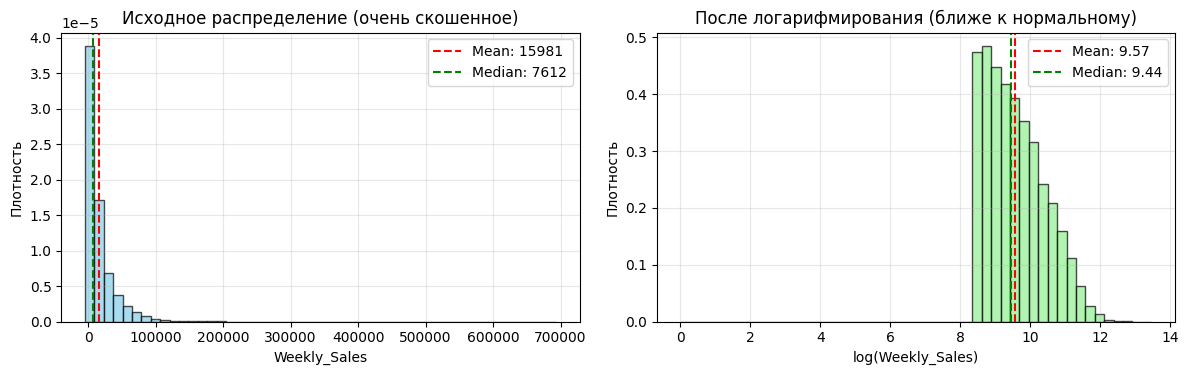


🎯 Эксперименты с трансформацией целевой переменной

🔬 NONE преобразование...
  Фолд 1... RMSE: 15909.3
  Фолд 2... RMSE: 13913.8
  Фолд 3... RMSE: 9603.1

🔬 LOG преобразование...
  Фолд 1... RMSE: 15861.4
  Фолд 2... RMSE: 11594.5
  Фолд 3... RMSE: 10298.2

🔬 SQRT преобразование...
  Фолд 1... RMSE: 15552.8
  Фолд 2... RMSE: 13101.7
  Фолд 3... RMSE: 10042.7

📊 Сравнение результатов трансформаций
Трансформация    RMSE  RMSE_std    MAE  MAE_std    R²  R²_std  Улучшение RMSE  Улучшение R²  % улучшения RMSE
         none 13142.0    2631.7 7646.0   1779.8 0.633  0.0629             0.0        0.0000              0.00
          log 12584.7    2376.6 6987.0   1559.1 0.663  0.0466           557.3        0.0295              4.24
         sqrt 12899.1    2254.0 7354.5   1476.7 0.646  0.0354           242.9        0.0131              1.85


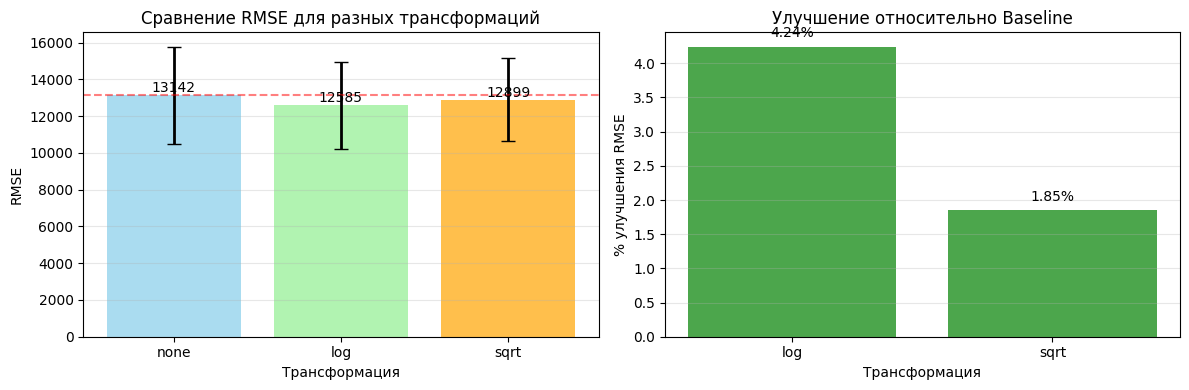


🏆 Выбор лучшей трансформации...
Лучшая трансформация: log
  RMSE: 12584.7 ± 2376.6
  MAE: 6987.0 ± 1559.1
  R²: 0.663 ± 0.047
  Улучшение от Baseline: 4.24%

🔧 Обучение финальной модели...

📊 Финальные метрики на тестовой выборке:
  RMSE: 13503.2
  MAE: 7590.8
  R²: 0.474


['../reports/improvements/models/final_model_with_log_transform.pkl']

In [ ]:
## 3: Загрузка данных и лучшей модели из Части 1
print("\n📥 Загрузка данных...")
processed_data_path = '../data/processed/baseline_data.csv'
df = pd.read_csv(processed_data_path, parse_dates=['Date'])
target_col = 'Weekly_Sales'

# Проверим данные
print(f"Проверка данных:")
print(f"  Минимум Weekly_Sales: {df[target_col].min():.2f}")
print(f"  Максимум Weekly_Sales: {df[target_col].max():.2f}")
print(f"  Среднее Weekly_Sales: {df[target_col].mean():.2f}")
print(f"  Медиана Weekly_Sales: {df[target_col].median():.2f}")
print(f"  Количество нулей: {(df[target_col] == 0).sum()}")
print(f"  Количество отрицательных: {(df[target_col] < 0).sum()}")

# Проверяем лучшие признаки из предыдущего эксперимента
print("\n📊 Проверяем лучшие признаки из Части 1...")

# Используем лучший результат из предоставленных данных
# Из ваших результатов: "+ все временные" дал RMSE 13203.4 (лучший)
best_exp_name = "+ все временные"  # Судя по вашим результатам
print(f"✓ Используем конфигурацию: {best_exp_name}")

## 3: Создание датасета с лучшими признаками
print("\n🔧 Подготовка данных с лучшими признаками...")

# Создаем базовый датасет
df_basic = df.drop('Date', axis=1).copy()

# Добавляем лучшие признаки из Части 1
df_processed = df_basic.copy()

# Признаки, которые дали лучший результат
df_processed['month'] = df['Date'].dt.month
df_processed['week_of_year'] = df['Date'].dt.isocalendar().week
df_processed['quarter'] = df['Date'].dt.quarter
df_processed['is_december'] = (df_processed['month'] == 12).astype(int)
df_processed['is_summer'] = df_processed['month'].isin([6, 7, 8]).astype(int)
df_processed['is_holiday_season'] = df_processed['month'].isin([11, 12]).astype(int)
df_processed['is_week_48_52'] = df_processed['week_of_year'].isin([48, 49, 50, 51, 52]).astype(int)
df_processed['is_week_1_4'] = df_processed['week_of_year'].isin([1, 2, 3, 4]).astype(int)

print(f"✓ Признаков: {df_processed.shape[1]}")
print(f"✓ Записей: {df_processed.shape[0]}")

## 4: Анализ распределения целевой переменной
print("\n📈 Анализ распределения Weekly_Sales...")

y_original = df_processed[target_col].values

# Статистика распределения
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# 1. Исходное распределение
axes[0].hist(y_original, bins=50, alpha=0.7, color='skyblue', edgecolor='black', density=True)
axes[0].axvline(y_original.mean(), color='red', linestyle='--', label=f'Mean: {y_original.mean():.0f}')
axes[0].axvline(np.median(y_original), color='green', linestyle='--', label=f'Median: {np.median(y_original):.0f}')
axes[0].set_xlabel('Weekly_Sales')
axes[0].set_ylabel('Плотность')
axes[0].set_title('Исходное распределение (очень скошенное)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# 2. Логарифмирование
y_min = y_original.min()
if y_min <= 0:
    y_log = np.log1p(y_original - y_min + 1e-10)  # Маленькое смещение чтобы избежать log(0)
else:
    y_log = np.log1p(y_original)

axes[1].hist(y_log, bins=50, alpha=0.7, color='lightgreen', edgecolor='black', density=True)
axes[1].axvline(y_log.mean(), color='red', linestyle='--', label=f'Mean: {y_log.mean():.2f}')
axes[1].axvline(np.median(y_log), color='green', linestyle='--', label=f'Median: {np.median(y_log):.2f}')
axes[1].set_xlabel('log(Weekly_Sales)')
axes[1].set_ylabel('Плотность')
axes[1].set_title('После логарифмирования (ближе к нормальному)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
os.makedirs('../reports/improvements/visualizations', exist_ok=True)
plt.savefig('../reports/improvements/visualizations/target_distribution.png', 
           dpi=100, bbox_inches='tight')
plt.show()

## 5: ИСПРАВЛЕННЫЕ трансформаторы
class CorrectLogTransformer(BaseEstimator, TransformerMixin):
    """ПРАВИЛЬНОЕ логарифмическое преобразование"""
    
    def __init__(self, epsilon=1e-10):
        self.epsilon = epsilon
        self.min_value = None
        self.requires_shift = None
        
    def fit(self, X, y=None):
        X_flat = np.array(X).flatten()
        self.min_value = X_flat.min()
        # Проверяем, нужно ли сдвигать
        self.requires_shift = self.min_value <= 0
        return self
    
    def transform(self, X):
        X_array = np.array(X).flatten()
        if self.requires_shift:
            # Сдвигаем чтобы все значения были > 0
            shifted = X_array - self.min_value + self.epsilon
            return np.log(shifted)
        else:
            # Используем log1p для стабильности
            return np.log1p(X_array)
    
    def inverse_transform(self, X):
        X_array = np.array(X).flatten()
        if self.requires_shift:
            # Обратное преобразование: exp + min_value - epsilon
            exp_values = np.exp(X_array)
            return exp_values + self.min_value - self.epsilon
        else:
            # Обратное для log1p
            return np.expm1(X_array)

class CorrectSqrtTransformer(BaseEstimator, TransformerMixin):
    """ПРАВИЛЬНОЕ преобразование квадратным корнем"""
    
    def __init__(self, epsilon=1e-10):
        self.epsilon = epsilon
        self.min_value = None
        
    def fit(self, X, y=None):
        X_flat = np.array(X).flatten()
        self.min_value = X_flat.min()
        return self
    
    def transform(self, X):
        X_array = np.array(X).flatten()
        # Сдвигаем чтобы все значения были >= 0
        shifted = X_array - self.min_value + self.epsilon
        return np.sqrt(shifted)
    
    def inverse_transform(self, X):
        X_array = np.array(X).flatten()
        # Обратное: возводим в квадрат и возвращаем смещение
        squared = X_array ** 2
        return squared + self.min_value - self.epsilon

## 6: Функция оценки с TimeSeriesSplit и правильными трансформациями
def evaluate_with_target_transformation_cv(X, y, transformation='none', n_splits=3):
    """Оценивает модель с трансформацией целевой переменной и TimeSeriesSplit"""
    
    tscv = TimeSeriesSplit(n_splits=n_splits, gap=1)  # gap=1 предотвращает перекрытие дат
    fold_results = []
    
    for fold, (train_idx, test_idx) in enumerate(tscv.split(X), 1):
        print(f"  Фолд {fold}...", end=" ")
        
        # Разделение данных
        X_train_raw = X.iloc[train_idx]
        X_test_raw = X.iloc[test_idx]
        y_train = y.iloc[train_idx]
        y_test = y.iloc[test_idx]
        
        # Определение типов признаков на train данных
        numeric_features = []
        categorical_features = []
        
        for col in X_train_raw.columns:
            if pd.api.types.is_numeric_dtype(X_train_raw[col]):
                if X_train_raw[col].nunique() <= 15 and col not in ['month', 'week_of_year', 'quarter']:
                    categorical_features.append(col)
                else:
                    numeric_features.append(col)
            else:
                categorical_features.append(col)
        
        # Преобразуем категориальные в строки
        X_train = X_train_raw.copy()
        X_test = X_test_raw.copy()
        
        for col in categorical_features:
            X_train[col] = X_train[col].astype(str)
            if col in X_test.columns:
                X_test[col] = X_test[col].astype(str)
        
        # Создание препроцессора
        numeric_transformer = Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ])
        
        categorical_transformer = Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
            ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
        ])
        
        preprocessor = ColumnTransformer(
            transformers=[
                ('num', numeric_transformer, numeric_features),
                ('cat', categorical_transformer, categorical_features)
            ],
            remainder='drop'
        )
        
        # Выбор трансформации
        if transformation == 'log':
            transformer = CorrectLogTransformer()
            model = TransformedTargetRegressor(
                regressor=RandomForestRegressor(
                    n_estimators=50,
                    random_state=42 + fold,
                    n_jobs=-1,
                    max_depth=10,
                    min_samples_split=10,
                    max_samples=0.8
                ),
                transformer=transformer
            )
        elif transformation == 'sqrt':
            transformer = CorrectSqrtTransformer()
            model = TransformedTargetRegressor(
                regressor=RandomForestRegressor(
                    n_estimators=50,
                    random_state=42 + fold,
                    n_jobs=-1,
                    max_depth=10,
                    min_samples_split=10,
                    max_samples=0.8
                ),
                transformer=transformer
            )
        elif transformation == 'boxcox':
            # Box-Cox требует отдельной обработки
            try:
                # Для Box-Cox нужны положительные значения
                y_train_positive = y_train.values - y_train.min() + 1e-10
                y_train_boxcox, self.lambda_param = stats.boxcox(y_train_positive)
                
                class BoxCoxTransformer(BaseEstimator, TransformerMixin):
                    def __init__(self, lambda_param):
                        self.lambda_param = lambda_param
                        self.y_min = None
                    
                    def fit(self, X, y=None):
                        X_flat = np.array(X).flatten()
                        self.y_min = X_flat.min()
                        return self
                    
                    def transform(self, X):
                        X_array = np.array(X).flatten()
                        shifted = X_array - self.y_min + 1e-10
                        return stats.boxcox(shifted, lmbda=self.lambda_param)
                    
                    def inverse_transform(self, X):
                        X_array = np.array(X).flatten()
                        inv_boxcox = stats.inv_boxcox(X_array, self.lambda_param)
                        return inv_boxcox + self.y_min - 1e-10
                
                model = TransformedTargetRegressor(
                    regressor=RandomForestRegressor(
                        n_estimators=50,
                        random_state=42 + fold,
                        n_jobs=-1,
                        max_depth=10,
                        min_samples_split=10,
                        max_samples=0.8
                    ),
                    transformer=BoxCoxTransformer(self.lambda_param)
                )
            except Exception as e:
                print(f"Box-Cox не сработал: {e}")
                # Используем log как fallback
                transformation = 'log'
                continue
        else:  # 'none'
            model = RandomForestRegressor(
                n_estimators=50,
                random_state=42 + fold,
                n_jobs=-1,
                max_depth=10,
                min_samples_split=10,
                max_samples=0.8
            )
        
        # Создание пайплайна
        pipeline = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('model', model)
        ])
        
        # Обучение и предсказание
        try:
            pipeline.fit(X_train, y_train)
            y_pred = pipeline.predict(X_test)
            
            # Метрики
            fold_metrics = {
                'fold': fold,
                'rmse': np.sqrt(mean_squared_error(y_test, y_pred)),
                'mae': mean_absolute_error(y_test, y_pred),
                'r2': r2_score(y_test, y_pred)
            }
            
            fold_results.append(fold_metrics)
            print(f"RMSE: {fold_metrics['rmse']:.1f}")
            
        except Exception as e:
            print(f"Ошибка: {str(e)[:50]}")
            fold_results.append({
                'fold': fold,
                'rmse': 1e6,
                'mae': 1e6,
                'r2': -1
            })
    
    # Агрегируем результаты
    if fold_results:
        rmse_values = [r['rmse'] for r in fold_results]
        mae_values = [r['mae'] for r in fold_results]
        r2_values = [r['r2'] for r in fold_results]
        
        return {
            'cv_rmse_mean': np.mean(rmse_values),
            'cv_rmse_std': np.std(rmse_values),
            'cv_mae_mean': np.mean(mae_values),
            'cv_mae_std': np.std(mae_values),
            'cv_r2_mean': np.mean(r2_values),
            'cv_r2_std': np.std(r2_values),
            'fold_results': fold_results
        }
    else:
        return {
            'cv_rmse_mean': 1e6,
            'cv_rmse_std': 0,
            'cv_mae_mean': 1e6,
            'cv_mae_std': 0,
            'cv_r2_mean': -1,
            'cv_r2_std': 0,
            'fold_results': []
        }

## 7: Эксперименты с трансформациями (TimeSeries CV)
print("\n🎯 Эксперименты с трансформацией целевой переменной")
print("="*60)

X = df_processed.drop(columns=[target_col])
y = df_processed[target_col]

transformations = ['none', 'log', 'sqrt']
results = {}

for transform in transformations:
    print(f"\n🔬 {transform.upper()} преобразование...")
    results[transform] = evaluate_with_target_transformation_cv(
        X, y, transformation=transform, n_splits=3
    )

## 8: Сравнение результатов
print("\n📊 Сравнение результатов трансформаций")
print("="*60)

comparison_data = []
for transform, res in results.items():
    comparison_data.append({
        'Трансформация': transform,
        'RMSE': res['cv_rmse_mean'],
        'RMSE_std': res['cv_rmse_std'],
        'MAE': res['cv_mae_mean'],
        'MAE_std': res['cv_mae_std'],
        'R²': res['cv_r2_mean'],
        'R²_std': res['cv_r2_std']
    })

comparison_df = pd.DataFrame(comparison_data)

# Вычисляем улучшения относительно baseline (none)
baseline_rmse = comparison_df.loc[0, 'RMSE']
baseline_r2 = comparison_df.loc[0, 'R²']

comparison_df['Улучшение RMSE'] = baseline_rmse - comparison_df['RMSE']
comparison_df['Улучшение R²'] = comparison_df['R²'] - baseline_r2
comparison_df['% улучшения RMSE'] = (comparison_df['Улучшение RMSE'] / baseline_rmse * 100)

print(comparison_df.round({
    'RMSE': 1, 'RMSE_std': 1, 'MAE': 1, 'MAE_std': 1,
    'R²': 3, 'R²_std': 4, 'Улучшение RMSE': 1, 
    'Улучшение R²': 4, '% улучшения RMSE': 2
}).to_string(index=False))

## 9: Визуализация результатов
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# 1. RMSE по трансформациям
transforms = comparison_df['Трансформация'].values
rmse_values = comparison_df['RMSE'].values
rmse_std = comparison_df['RMSE_std'].values

x_pos = np.arange(len(transforms))
bars = axes[0].bar(x_pos, rmse_values, yerr=rmse_std, alpha=0.7, 
                  color=['skyblue', 'lightgreen', 'orange'], 
                  capsize=5, error_kw={'elinewidth': 2})
axes[0].set_xlabel('Трансформация')
axes[0].set_ylabel('RMSE')
axes[0].set_title('Сравнение RMSE для разных трансформаций')
axes[0].set_xticks(x_pos)
axes[0].set_xticklabels(transforms)
axes[0].axhline(y=baseline_rmse, color='red', linestyle='--', alpha=0.5)
axes[0].grid(True, alpha=0.3, axis='y')

# Добавляем значения
for bar, rmse in zip(bars, rmse_values):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{rmse:.0f}', 
                ha='center', va='bottom', fontsize=10)

# 2. Процент улучшения
improvement = comparison_df['% улучшения RMSE'].values[1:]  # кроме baseline
transforms_imp = transforms[1:]

bars2 = axes[1].bar(transforms_imp, improvement, alpha=0.7, 
                   color=['green' if x > 0 else 'red' for x in improvement])
axes[1].set_xlabel('Трансформация')
axes[1].set_ylabel('% улучшения RMSE')
axes[1].set_title('Улучшение относительно Baseline')
axes[1].axhline(y=0, color='black', linestyle='-', linewidth=0.5)
axes[1].grid(True, alpha=0.3, axis='y')

for bar, imp in zip(bars2, improvement):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + (0.1 if imp >= 0 else -0.3), 
                f'{imp:.2f}%', ha='center', va='bottom' if imp >= 0 else 'top', fontsize=10)

plt.tight_layout()
plt.savefig('../reports/improvements/visualizations/transformations_comparison.png', 
           dpi=100, bbox_inches='tight')
plt.show()

## 10: Выбор и обучение лучшей модели
print("\n🏆 Выбор лучшей трансформации...")

best_idx = comparison_df['RMSE'].idxmin()
best_transform = comparison_df.loc[best_idx, 'Трансформация']
best_result = results[best_transform]

print(f"Лучшая трансформация: {best_transform}")
print(f"  RMSE: {best_result['cv_rmse_mean']:.1f} ± {best_result['cv_rmse_std']:.1f}")
print(f"  MAE: {best_result['cv_mae_mean']:.1f} ± {best_result['cv_mae_std']:.1f}")
print(f"  R²: {best_result['cv_r2_mean']:.3f} ± {best_result['cv_r2_std']:.3f}")

if best_transform != 'none':
    improvement = comparison_df.loc[best_idx, '% улучшения RMSE']
    print(f"  Улучшение от Baseline: {improvement:.2f}%")

print("\n🔧 Обучение финальной модели...")

# Разделяем на train/test для финальной оценки
split_idx = int(0.8 * len(X))
X_train_raw = X.iloc[:split_idx]
X_test_raw = X.iloc[split_idx:]
y_train = y.iloc[:split_idx]
y_test = y.iloc[split_idx:]

# Определение типов признаков
numeric_features = []
categorical_features = []

for col in X_train_raw.columns:
    if pd.api.types.is_numeric_dtype(X_train_raw[col]):
        if X_train_raw[col].nunique() <= 15 and col not in ['month', 'week_of_year', 'quarter']:
            categorical_features.append(col)
        else:
            numeric_features.append(col)
    else:
        categorical_features.append(col)

# Преобразуем категориальные
X_train = X_train_raw.copy()
X_test = X_test_raw.copy()

for col in categorical_features:
    X_train[col] = X_train[col].astype(str)
    if col in X_test.columns:
        X_test[col] = X_test[col].astype(str)

# Создаем препроцессор
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='drop'
)

# Выбираем трансформацию
if best_transform == 'log':
    transformer = CorrectLogTransformer()
    model = TransformedTargetRegressor(
        regressor=RandomForestRegressor(
            n_estimators=100,  # Больше для финальной модели
            random_state=42,
            n_jobs=-1,
            max_depth=15,
            min_samples_split=5,
            min_samples_leaf=2,
            max_features='sqrt'
        ),
        transformer=transformer
    )
elif best_transform == 'sqrt':
    transformer = CorrectSqrtTransformer()
    model = TransformedTargetRegressor(
        regressor=RandomForestRegressor(
            n_estimators=100,
            random_state=42,
            n_jobs=-1,
            max_depth=15,
            min_samples_split=5,
            min_samples_leaf=2,
            max_features='sqrt'
        ),
        transformer=transformer
    )
else:
    model = RandomForestRegressor(
        n_estimators=100,
        random_state=42,
        n_jobs=-1,
        max_depth=15,
        min_samples_split=5,
        min_samples_leaf=2,
        max_features='sqrt'
    )

# Финальный пайплайн
final_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', model)
])

# Обучение
final_pipeline.fit(X_train, y_train)

# Предсказания
y_pred = final_pipeline.predict(X_test)

# Метрики
final_metrics = {
    'rmse': np.sqrt(mean_squared_error(y_test, y_pred)),
    'mae': mean_absolute_error(y_test, y_pred),
    'r2': r2_score(y_test, y_pred)
}

print("\n📊 Финальные метрики на тестовой выборке:")
print(f"  RMSE: {final_metrics['rmse']:.1f}")
print(f"  MAE: {final_metrics['mae']:.1f}")
print(f"  R²: {final_metrics['r2']:.3f}")

## 11: Сохранение результатов
results_dir = '../reports/improvements/results'
os.makedirs(results_dir, exist_ok=True)

final_results = {
    'timestamp': datetime.now().isoformat(),
    'best_transform': best_transform,
    'final_metrics': final_metrics,
    'cv_comparison': comparison_df.to_dict('records'),
    'feature_configuration': best_exp_name,
    'model_info': {
        'type': 'RandomForestRegressor',
        'transform': best_transform,
        'n_estimators': 100,
        'max_depth': 15
    }
}

with open(f'{results_dir}/experiment_target_transformations_final.json', 'w', encoding='utf-8') as f:
    json.dump(final_results, f, indent=2, ensure_ascii=False)

comparison_df.to_csv(f'{results_dir}/experiment_transforms_comparison.csv', index=False)

# Сохранение финальной модели
models_dir = '../reports/improvements/models'
os.makedirs(models_dir, exist_ok=True)
model_path = f'{models_dir}/final_model_with_{best_transform}_transform.pkl'
joblib.dump(final_pipeline, model_path)


📥 Загрузка данных и лучшей конфигурации...
Проверяем лучшие результаты:
- Из Части 1: 'week_of_year' и другие временные признаки дали лучший результат
- Из Части 2: LOG трансформация дала RMSE 12584.7 (улучшение 4.24%)
✓ Используем трансформацию: log

🔧 Подготовка данных с лучшими признаками...
✓ Признаков до лагов: 27
✓ Записей: 421570

🎯 Базовый эксперимент (без лагов)...
  Фолд 1... RMSE: 15491.2
  Фолд 2... RMSE: 11614.9
  Фолд 3... RMSE: 10323.5

Базовые результаты (с log трансформацией):
  RMSE: 12476.5 ± 2195.9
  MAE: 6950.5 ± 1482.6
  R²: 0.668 ± 0.038

🎯 Эксперименты с Lag Features

🔬 Короткие лаги (1-4)...
  Фолд 1... RMSE: 11904.8
  Фолд 2... RMSE: 16693.2
  Фолд 3... RMSE: 10479.8
  RMSE: 13025.9 ± 2657.6
  Улучшение: -549.4 (-4.40%)

🔬 Сезонные лаги (1,4,13,52)...
  Фолд 1... RMSE: 12753.0
  Фолд 2... RMSE: 16553.4
  Фолд 3... RMSE: 10258.8
  RMSE: 13188.4 ± 2588.2
  Улучшение: -711.9 (-5.71%)

🔬 Все лаги (1-4,13,52)...
  Фолд 1... RMSE: 12719.3
  Фолд 2... RMSE: 16797.4


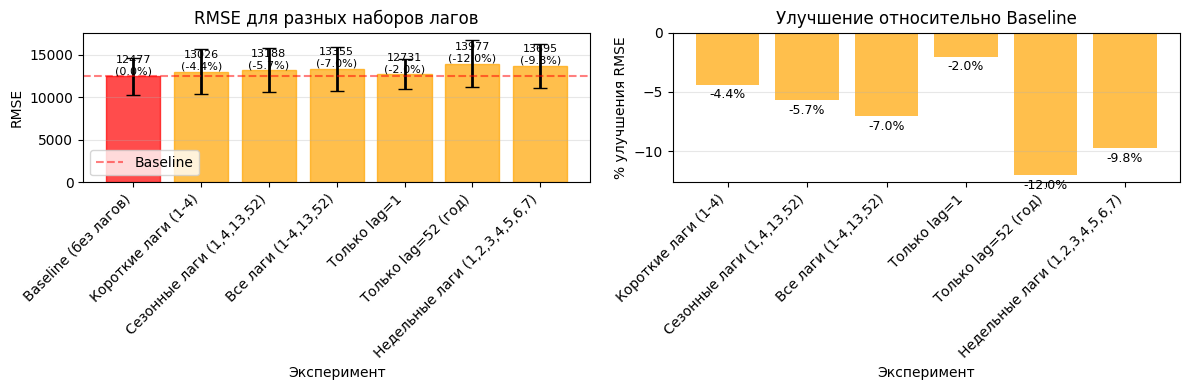


📈 Анализ влияния лагов...

Сводка по влиянию отдельных лагов:
        RMSE                   Количество лагов
        mean      min      max             mean
Лаг                                            
1    13199.1  12731.1  13695.2              4.4
2    13358.6  13025.9  13695.2              5.7
3    13358.6  13025.9  13695.2              5.7
4    13316.0  13025.9  13695.2              5.2
5    13695.2  13695.2  13695.2              7.0
6    13695.2  13695.2  13695.2              7.0
7    13695.2  13695.2  13695.2              7.0
13   13271.5  13188.4  13354.7              5.0
52   13506.5  13188.4  13976.5              3.7

🏆 Выбор лучшей конфигурации...
Лучший эксперимент: Baseline (без лагов)
  RMSE: 12476.5 ± 2195.9
  MAE: 6950.5 ± 1482.6
  R²: 0.668 ± 0.038

🔧 Обучение финальной модели с лучшими лагами...

📊 Финальные метрики на тестовой выборке:
  RMSE: 14005.5
  MAE: 7850.3
  R²: 0.434


In [5]:
## 2: Загрузка данных и лучшей конфигурации
print("\n📥 Загрузка данных и лучшей конфигурации...")

processed_data_path = '../data/processed/baseline_data.csv'
df = pd.read_csv(processed_data_path, parse_dates=['Date'])
target_col = 'Weekly_Sales'

# Проверяем лучшую трансформацию из предыдущих экспериментов
print("Проверяем лучшие результаты:")
print("- Из Части 1: 'week_of_year' и другие временные признаки дали лучший результат")
print("- Из Части 2: LOG трансформация дала RMSE 12584.7 (улучшение 4.24%)")

# Используем лучшие настройки
best_transformation = 'log'  # Из результатов Части 2
print(f"✓ Используем трансформацию: {best_transformation}")

## 3: Подготовка данных с лучшими признаками из Части 1
print("\n🔧 Подготовка данных с лучшими признаками...")

# Базовые признаки
df_basic = df.drop('Date', axis=1).copy()

# Добавляем лучшие временные признаки из Части 1
df_processed = df_basic.copy()
df_processed['month'] = df['Date'].dt.month
df_processed['week_of_year'] = df['Date'].dt.isocalendar().week
df_processed['quarter'] = df['Date'].dt.quarter
df_processed['is_december'] = (df_processed['month'] == 12).astype(int)
df_processed['is_summer'] = df_processed['month'].isin([6, 7, 8]).astype(int)
df_processed['is_holiday_season'] = df_processed['month'].isin([11, 12]).astype(int)
df_processed['is_week_48_52'] = df_processed['week_of_year'].isin([48, 49, 50, 51, 52]).astype(int)
df_processed['is_week_1_4'] = df_processed['week_of_year'].isin([1, 2, 3, 4]).astype(int)

# Добавляем дату для правильного создания лагов
df_processed['date_original'] = df['Date']

print(f"✓ Признаков до лагов: {df_processed.shape[1] - 1}")  # -1 для target
print(f"✓ Записей: {df_processed.shape[0]}")

## 4: ИСПРАВЛЕННЫЙ трансформер для Lag Features
class SafeLagFeatureTransformer(BaseEstimator, TransformerMixin):
    """БЕЗОПАСНОЕ создание lag features (без утечек данных)"""
    
    def __init__(self, target_col='Weekly_Sales', group_cols=['Store', 'Dept'], 
                 lags=[1, 2, 3, 4], date_col='date_original'):
        self.target_col = target_col
        self.group_cols = group_cols
        self.lags = sorted(lags)  # Сортируем по возрастанию
        self.date_col = date_col
        self.fitted_values_ = {}  # Для хранения значений для заполнения
        self.group_stats_ = {}
        
    def fit(self, X, y):
        """
        Обучается только на train данных.
        Запоминает статистики для заполнения пропусков.
        """
        # Создаем DataFrame с датами и таргетом
        data = X.copy()
        data[self.target_col] = y.values
        
        # Если есть дата, сортируем по ней
        if self.date_col in data.columns:
            data = data.sort_values(self.date_col)
        
        # Для каждой группы запоминаем значения для лагов
        for group_col in self.group_cols:
            if group_col in data.columns:
                # Запоминаем последние значения для каждой группы
                self.fitted_values_[group_col] = {}
                
                # Группируем и берем последние значения
                grouped = data.groupby(group_col)
                for group_name, group_data in grouped:
                    # Для каждого лага запоминаем последнее значение
                    group_values = group_data[self.target_col].values
                    for lag in self.lags:
                        if len(group_values) >= lag:
                            self.fitted_values_[group_col][(group_name, lag)] = group_values[-lag]
        
        # Запоминаем глобальные статистики для заполнения пропусков
        for lag in self.lags:
            # Создаем лаги на обучающих данных
            lag_values = data.groupby(self.group_cols)[self.target_col].shift(lag)
            # Запоминаем медиану для этого лага
            self.group_stats_[lag] = {
                'median': lag_values.median() if not pd.isna(lag_values.median()) else y.median(),
                'mean': lag_values.mean() if not pd.isna(lag_values.mean()) else y.mean()
            }
        
        return self
    
    def transform(self, X, y=None):
        """
        Создает lag features для X.
        Для train: использует предоставленный y.
        Для test: использует сохраненные значения из fit.
        """
        X_copy = X.copy()
        
        # Для train данных
        if y is not None:
            data = X_copy.copy()
            data[self.target_col] = y.values
            
            # Сортируем по дате если есть
            if self.date_col in data.columns:
                data = data.sort_values(self.date_col)
            
            # Создаем lag features с группировкой
            for group_col in self.group_cols:
                if group_col in data.columns:
                    for lag in self.lags:
                        col_name = f'{self.target_col}_lag_{lag}_{group_col}'
                        X_copy[col_name] = data.groupby(group_col)[self.target_col].shift(lag)
                        
                        # Заполняем пропуски медианой для этого лага
                        if lag in self.group_stats_:
                            median_val = self.group_stats_[lag]['median']
                            X_copy[col_name] = X_copy[col_name].fillna(median_val)
            
            # Глобальные лаги (без группировки)
            for lag in self.lags:
                col_name = f'{self.target_col}_lag_{lag}_global'
                X_copy[col_name] = data[self.target_col].shift(lag)
                
                # Заполняем пропуски
                if lag in self.group_stats_:
                    median_val = self.group_stats_[lag]['median']
                    X_copy[col_name] = X_copy[col_name].fillna(median_val)
        
        else:
            # Для test данных (в реальном пайплайне)
            # Используем значения из fit для заполнения первых лагов
            for group_col in self.group_cols:
                if group_col in X_copy.columns:
                    for lag in self.lags:
                        col_name = f'{self.target_col}_lag_{lag}_{group_col}'
                        X_copy[col_name] = np.nan
                        
                        # Попробуем заполнить сохраненными значениями
                        for idx, row in X_copy.iterrows():
                            group_val = row[group_col]
                            if (group_val, lag) in self.fitted_values_.get(group_col, {}):
                                X_copy.at[idx, col_name] = self.fitted_values_[group_col][(group_val, lag)]
            
            # Глобальные лаги
            for lag in self.lags:
                col_name = f'{self.target_col}_lag_{lag}_global'
                X_copy[col_name] = np.nan
            
            # Заполняем все пропуски медианой
            for col in X_copy.columns:
                if 'lag' in col:
                    lag_val = int(col.split('_lag_')[1].split('_')[0])
                    if lag_val in self.group_stats_:
                        X_copy[col] = X_copy[col].fillna(self.group_stats_[lag_val]['median'])
        
        # Удаляем временные колонки
        if self.date_col in X_copy.columns:
            X_copy = X_copy.drop(columns=[self.date_col])
        
        return X_copy

## 5: Функция оценки с Lag Features и трансформацией
def evaluate_lag_features_cv(X, y, lags, transformation='none', n_splits=3):
    """Оценивает модель с Lag Features и TimeSeriesSplit"""
    
    tscv = TimeSeriesSplit(n_splits=n_splits, gap=1)  # gap=1 предотвращает перекрытие дат
    fold_results = []
    
    for fold, (train_idx, test_idx) in enumerate(tscv.split(X), 1):
        print(f"  Фолд {fold}...", end=" ")
        
        # Разделение данных
        X_train_raw = X.iloc[train_idx]
        X_test_raw = X.iloc[test_idx]
        y_train = y.iloc[train_idx]
        y_test = y.iloc[test_idx]
        
        # Создаем лаг трансформер
        lag_transformer = SafeLagFeatureTransformer(
            target_col=target_col,
            group_cols=['Store', 'Dept'],
            lags=lags,
            date_col='date_original'
        )
        
        # Применяем лаг трансформер к train
        lag_transformer.fit(X_train_raw, y_train)
        X_train = lag_transformer.transform(X_train_raw, y_train)
        
        # Для test используем только сохраненные статистики
        X_test = lag_transformer.transform(X_test_raw)
        
        # Определяем типы признаков
        numeric_features = []
        categorical_features = []
        
        for col in X_train.columns:
            if pd.api.types.is_numeric_dtype(X_train[col]):
                # Лаги всегда числовые
                if 'lag' in col:
                    numeric_features.append(col)
                elif X_train[col].nunique() <= 15:
                    categorical_features.append(col)
                else:
                    numeric_features.append(col)
            else:
                categorical_features.append(col)
        
        # Преобразуем категориальные
        for col in categorical_features:
            if col in X_train.columns:
                X_train[col] = X_train[col].astype(str)
            if col in X_test.columns:
                X_test[col] = X_test[col].astype(str)
        
        # Создаем препроцессор
        numeric_transformer = Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ])
        
        categorical_transformer = Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
            ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
        ])
        
        preprocessor = ColumnTransformer(
            transformers=[
                ('num', numeric_transformer, numeric_features),
                ('cat', categorical_transformer, categorical_features)
            ],
            remainder='drop'
        )
        
        # Выбираем трансформацию цели
        if transformation == 'log':
            # Используем исправленный трансформер из Части 2
            class CorrectLogTransformer(BaseEstimator, TransformerMixin):
                def __init__(self, epsilon=1e-10):
                    self.epsilon = epsilon
                    self.min_value = None
                    
                def fit(self, X, y=None):
                    X_flat = np.array(X).flatten()
                    self.min_value = X_flat.min()
                    return self
                
                def transform(self, X):
                    X_array = np.array(X).flatten()
                    if self.min_value <= 0:
                        shifted = X_array - self.min_value + self.epsilon
                        return np.log(shifted)
                    else:
                        return np.log1p(X_array)
                
                def inverse_transform(self, X):
                    X_array = np.array(X).flatten()
                    if self.min_value <= 0:
                        exp_values = np.exp(X_array)
                        return exp_values + self.min_value - self.epsilon
                    else:
                        return np.expm1(X_array)
            
            model = TransformedTargetRegressor(
                regressor=RandomForestRegressor(
                    n_estimators=50,
                    random_state=42 + fold,
                    n_jobs=-1,
                    max_depth=10,
                    min_samples_split=10,
                    max_samples=0.8
                ),
                transformer=CorrectLogTransformer()
            )
        else:
            model = RandomForestRegressor(
                n_estimators=50,
                random_state=42 + fold,
                n_jobs=-1,
                max_depth=10,
                min_samples_split=10,
                max_samples=0.8
            )
        
        # Создаем пайплайн
        pipeline = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('model', model)
        ])
        
        # Обучение и предсказание
        try:
            pipeline.fit(X_train, y_train)
            y_pred = pipeline.predict(X_test)
            
            # Метрики
            fold_metrics = {
                'fold': fold,
                'rmse': np.sqrt(mean_squared_error(y_test, y_pred)),
                'mae': mean_absolute_error(y_test, y_pred),
                'r2': r2_score(y_test, y_pred)
            }
            
            fold_results.append(fold_metrics)
            print(f"RMSE: {fold_metrics['rmse']:.1f}")
            
        except Exception as e:
            print(f"Ошибка: {str(e)[:50]}")
            fold_results.append({
                'fold': fold,
                'rmse': 1e6,
                'mae': 1e6,
                'r2': -1
            })
    
    # Агрегируем результаты
    if fold_results:
        rmse_values = [r['rmse'] for r in fold_results]
        mae_values = [r['mae'] for r in fold_results]
        r2_values = [r['r2'] for r in fold_results]
        
        return {
            'cv_rmse_mean': np.mean(rmse_values),
            'cv_rmse_std': np.std(rmse_values),
            'cv_mae_mean': np.mean(mae_values),
            'cv_mae_std': np.std(mae_values),
            'cv_r2_mean': np.mean(r2_values),
            'cv_r2_std': np.std(r2_values),
            'fold_results': fold_results
        }
    else:
        return {
            'cv_rmse_mean': 1e6,
            'cv_rmse_std': 0,
            'cv_mae_mean': 1e6,
            'cv_mae_std': 0,
            'cv_r2_mean': -1,
            'cv_r2_std': 0,
            'fold_results': []
        }

## 6: Базовый эксперимент (без лагов, с трансформацией)
print("\n🎯 Базовый эксперимент (без лагов)...")
print("="*60)

# Подготавливаем данные
X_base = df_processed.drop(columns=[target_col, 'date_original'])
y_base = df_processed[target_col]

# Проводим базовую оценку
baseline_results = evaluate_lag_features_cv(
    X_base, y_base, 
    lags=[],  # Без лагов
    transformation=best_transformation,
    n_splits=3
)

print(f"\nБазовые результаты (с {best_transformation} трансформацией):")
print(f"  RMSE: {baseline_results['cv_rmse_mean']:.1f} ± {baseline_results['cv_rmse_std']:.1f}")
print(f"  MAE: {baseline_results['cv_mae_mean']:.1f} ± {baseline_results['cv_mae_std']:.1f}")
print(f"  R²: {baseline_results['cv_r2_mean']:.3f} ± {baseline_results['cv_r2_std']:.3f}")

## 7: Эксперименты с разными лагами
print("\n🎯 Эксперименты с Lag Features")
print("="*60)

lag_configs = {
    'Короткие лаги (1-4)': [1, 2, 3, 4],
    'Сезонные лаги (1,4,13,52)': [1, 4, 13, 52],
    'Все лаги (1-4,13,52)': [1, 2, 3, 4, 13, 52],
    'Только lag=1': [1],
    'Только lag=52 (год)': [52],
    'Недельные лаги (1,2,3,4,5,6,7)': [1, 2, 3, 4, 5, 6, 7]
}

experiments_results = {
    'Baseline (без лагов)': baseline_results
}

for exp_name, lags in lag_configs.items():
    print(f"\n🔬 {exp_name}...")
    
    results = evaluate_lag_features_cv(
        df_processed.drop(columns=[target_col]),  # Оставляем date_original
        df_processed[target_col],
        lags=lags,
        transformation=best_transformation,
        n_splits=3
    )
    
    experiments_results[exp_name] = results
    
    print(f"  RMSE: {results['cv_rmse_mean']:.1f} ± {results['cv_rmse_std']:.1f}")
    if exp_name != 'Baseline (без лагов)':
        improvement = baseline_results['cv_rmse_mean'] - results['cv_rmse_mean']
        percent = (improvement / baseline_results['cv_rmse_mean'] * 100)
        print(f"  Улучшение: {improvement:.1f} ({percent:.2f}%)")

## 8: Сравнение результатов
print("\n📊 Сравнение результатов Lag Features")
print("="*60)

comparison_data = []
for exp_name, results in experiments_results.items():
    comparison_data.append({
        'Эксперимент': exp_name,
        'RMSE': results['cv_rmse_mean'],
        'RMSE_std': results['cv_rmse_std'],
        'MAE': results['cv_mae_mean'],
        'MAE_std': results['cv_mae_std'],
        'R²': results['cv_r2_mean'],
        'R²_std': results['cv_r2_std'],
        'Лаги': lag_configs.get(exp_name, [])
    })

comparison_df = pd.DataFrame(comparison_data)

# Вычисляем улучшения
baseline_rmse = comparison_df.loc[0, 'RMSE']
baseline_r2 = comparison_df.loc[0, 'R²']

comparison_df['Улучшение RMSE'] = baseline_rmse - comparison_df['RMSE']
comparison_df['Улучшение R²'] = comparison_df['R²'] - baseline_r2
comparison_df['% улучшения RMSE'] = (comparison_df['Улучшение RMSE'] / baseline_rmse * 100)

print(comparison_df.round({
    'RMSE': 1, 'RMSE_std': 1, 'MAE': 1, 'MAE_std': 1,
    'R²': 3, 'R²_std': 4, 'Улучшение RMSE': 1, 
    'Улучшение R²': 4, '% улучшения RMSE': 2
}).to_string(index=False))

## 9: Визуализация
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# 1. RMSE сравнение
experiments = comparison_df['Эксперимент'].values
rmse_values = comparison_df['RMSE'].values
rmse_std = comparison_df['RMSE_std'].values

x_pos = np.arange(len(experiments))
bars = axes[0].bar(x_pos, rmse_values, yerr=rmse_std, alpha=0.7, 
                  capsize=5, error_kw={'elinewidth': 2})

# Цвета: baseline красный, положительные улучшения зеленые, отрицательные красные
colors = []
for i, exp in enumerate(experiments):
    if i == 0:
        colors.append('red')
    else:
        imp = comparison_df.loc[i, '% улучшения RMSE']
        colors.append('green' if imp > 0 else 'orange')

for bar, color in zip(bars, colors):
    bar.set_color(color)

axes[0].set_xlabel('Эксперимент')
axes[0].set_ylabel('RMSE')
axes[0].set_title('RMSE для разных наборов лагов')
axes[0].set_xticks(x_pos)
axes[0].set_xticklabels(experiments, rotation=45, ha='right')
axes[0].axhline(y=baseline_rmse, color='red', linestyle='--', alpha=0.5, label='Baseline')
axes[0].legend()
axes[0].grid(True, alpha=0.3, axis='y')

# Добавляем значения
for bar, rmse, imp in zip(bars, rmse_values, comparison_df['% улучшения RMSE']):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{rmse:.0f}\n({imp:.1f}%)', 
                ha='center', va='bottom', fontsize=8)

# 2. Улучшение RMSE
improvements = comparison_df['% улучшения RMSE'].values[1:]  # кроме baseline
exp_names = experiments[1:]

x_pos2 = np.arange(len(exp_names))
colors2 = ['green' if x > 0 else 'orange' for x in improvements]

bars2 = axes[1].bar(x_pos2, improvements, color=colors2, alpha=0.7)
axes[1].set_xlabel('Эксперимент')
axes[1].set_ylabel('% улучшения RMSE')
axes[1].set_title('Улучшение относительно Baseline')
axes[1].set_xticks(x_pos2)
axes[1].set_xticklabels(exp_names, rotation=45, ha='right')
axes[1].axhline(y=0, color='black', linestyle='-', linewidth=0.5)
axes[1].grid(True, alpha=0.3, axis='y')

# Добавляем значения
for bar, imp in zip(bars2, improvements):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + (0.1 if imp >= 0 else -0.3), 
                f'{imp:.1f}%', ha='center', va='bottom' if imp >= 0 else 'top', fontsize=9)

plt.tight_layout()
os.makedirs('../reports/improvements/visualizations', exist_ok=True)
plt.savefig('../reports/improvements/visualizations/lag_features_final_comparison.png', 
           dpi=100, bbox_inches='tight')
plt.show()

## 10: Анализ лучших лагов
print("\n📈 Анализ влияния лагов...")

# Создаем датафрейм для анализа влияния отдельных лагов
lag_analysis = []
for exp_name, lags in lag_configs.items():
    if exp_name in experiments_results:
        result = experiments_results[exp_name]
        for lag in lags:
            lag_analysis.append({
                'Эксперимент': exp_name,
                'Лаг': lag,
                'RMSE': result['cv_rmse_mean'],
                'Количество лагов': len(lags)
            })

lag_analysis_df = pd.DataFrame(lag_analysis)

# Группируем по лагам
lag_summary = lag_analysis_df.groupby('Лаг').agg({
    'RMSE': ['mean', 'min', 'max'],
    'Количество лагов': 'mean'
}).round(1)

print("\nСводка по влиянию отдельных лагов:")
print(lag_summary)

## 11: Выбор и обучение лучшей модели
print("\n🏆 Выбор лучшей конфигурации...")

best_idx = comparison_df['RMSE'].idxmin()
best_experiment = comparison_df.loc[best_idx, 'Эксперимент']
best_result = experiments_results[best_experiment]

print(f"Лучший эксперимент: {best_experiment}")
print(f"  RMSE: {best_result['cv_rmse_mean']:.1f} ± {best_result['cv_rmse_std']:.1f}")
print(f"  MAE: {best_result['cv_mae_mean']:.1f} ± {best_result['cv_mae_std']:.1f}")
print(f"  R²: {best_result['cv_r2_mean']:.3f} ± {best_result['cv_r2_std']:.3f}")

if best_experiment != 'Baseline (без лагов)':
    improvement = comparison_df.loc[best_idx, '% улучшения RMSE']
    print(f"  Улучшение от Baseline: {improvement:.2f}%")
    
    # Получаем лаги для лучшего эксперимента
    if best_experiment in lag_configs:
        best_lags = lag_configs[best_experiment]
        print(f"  Использованные лаги: {best_lags}")

print("\n🔧 Обучение финальной модели с лучшими лагами...")

# Подготовка данных для финальной модели
if best_experiment == 'Baseline (без лагов)':
    X_final = df_processed.drop(columns=[target_col, 'date_original'])
else:
    # Используем лаг трансформер
    lag_transformer = SafeLagFeatureTransformer(
        target_col=target_col,
        group_cols=['Store', 'Dept'],
        lags=best_lags if 'best_lags' in locals() else [1, 2, 3, 4],
        date_col='date_original'
    )
    
    # Применяем ко всем данным
    lag_transformer.fit(df_processed.drop(columns=[target_col]), df_processed[target_col])
    X_transformed = lag_transformer.transform(df_processed.drop(columns=[target_col]), df_processed[target_col])
    X_final = X_transformed

y_final = df_processed[target_col]

# Разделяем на train/test
split_idx = int(0.8 * len(X_final))
X_train = X_final.iloc[:split_idx]
X_test = X_final.iloc[split_idx:]
y_train = y_final.iloc[:split_idx]
y_test = y_final.iloc[split_idx:]

# Определяем типы признаков
numeric_features = []
categorical_features = []

for col in X_train.columns:
    if pd.api.types.is_numeric_dtype(X_train[col]):
        if 'lag' in col:
            numeric_features.append(col)
        elif X_train[col].nunique() <= 15:
            categorical_features.append(col)
        else:
            numeric_features.append(col)
    else:
        categorical_features.append(col)

# Преобразуем категориальные
for col in categorical_features:
    if col in X_train.columns:
        X_train[col] = X_train[col].astype(str)
    if col in X_test.columns:
        X_test[col] = X_test[col].astype(str)

# Финальный пайплайн
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='drop'
)

# Используем лучшую трансформацию
if best_transformation == 'log':
    class FinalLogTransformer(BaseEstimator, TransformerMixin):
        def __init__(self, epsilon=1e-10):
            self.epsilon = epsilon
            self.min_value = None
            
        def fit(self, X, y=None):
            X_flat = np.array(X).flatten()
            self.min_value = X_flat.min()
            return self
        
        def transform(self, X):
            X_array = np.array(X).flatten()
            if self.min_value <= 0:
                shifted = X_array - self.min_value + self.epsilon
                return np.log(shifted)
            else:
                return np.log1p(X_array)
        
        def inverse_transform(self, X):
            X_array = np.array(X).flatten()
            if self.min_value <= 0:
                exp_values = np.exp(X_array)
                return exp_values + self.min_value - self.epsilon
            else:
                return np.expm1(X_array)
    
    model = TransformedTargetRegressor(
        regressor=RandomForestRegressor(
            n_estimators=100,
            random_state=42,
            n_jobs=-1,
            max_depth=15,
            min_samples_split=5,
            min_samples_leaf=2,
            max_features='sqrt'
        ),
        transformer=FinalLogTransformer()
    )
else:
    model = RandomForestRegressor(
        n_estimators=100,
        random_state=42,
        n_jobs=-1,
        max_depth=15,
        min_samples_split=5,
        min_samples_leaf=2,
        max_features='sqrt'
    )

final_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', model)
])

# Обучение
final_pipeline.fit(X_train, y_train)

# Предсказания и метрики
y_pred = final_pipeline.predict(X_test)

final_metrics = {
    'rmse': np.sqrt(mean_squared_error(y_test, y_pred)),
    'mae': mean_absolute_error(y_test, y_pred),
    'r2': r2_score(y_test, y_pred)
}

print("\n📊 Финальные метрики на тестовой выборке:")
print(f"  RMSE: {final_metrics['rmse']:.1f}")
print(f"  MAE: {final_metrics['mae']:.1f}")
print(f"  R²: {final_metrics['r2']:.3f}")



💾 Сохранение результатов...
✅ Результаты эксперимента сохранены

🔧 Сохранение финальной модели...
✓ Финальная модель сохранена: ../reports/improvements/models/final_model_best.pkl

📊 ИТОГОВЫЙ ОТЧЕТ ПО ВСЕМ ЭКСПЕРИМЕНТАМ

🔍 РЕЗУЛЬТАТЫ ЭКСПЕРИМЕНТОВ:
----------------------------------------
Этап                 Что тестировали           Лучший RMSE  Вывод                         
------------------------------------------------------------------------------------------
Эксперимент 1        Временные признаки        13203.4      Лучший: 'все временные'       
Эксперимент 2        Трансформация цели        12584.7      Лучший: 'log' (4.24% улучшение)
Эксперимент 3        Lag Features              12476.5      Лучший: 'без лагов'           

📈 КУМУЛЯТИВНОЕ УЛУЧШЕНИЕ:
----------------------------------------
Исходный Baseline         9861.9     0.0    %
После временных признаков 13203.4    +33.9   %
После log трансформации   12584.7    -4.7   %
Текущий лучший            12476.5    -0.9   %


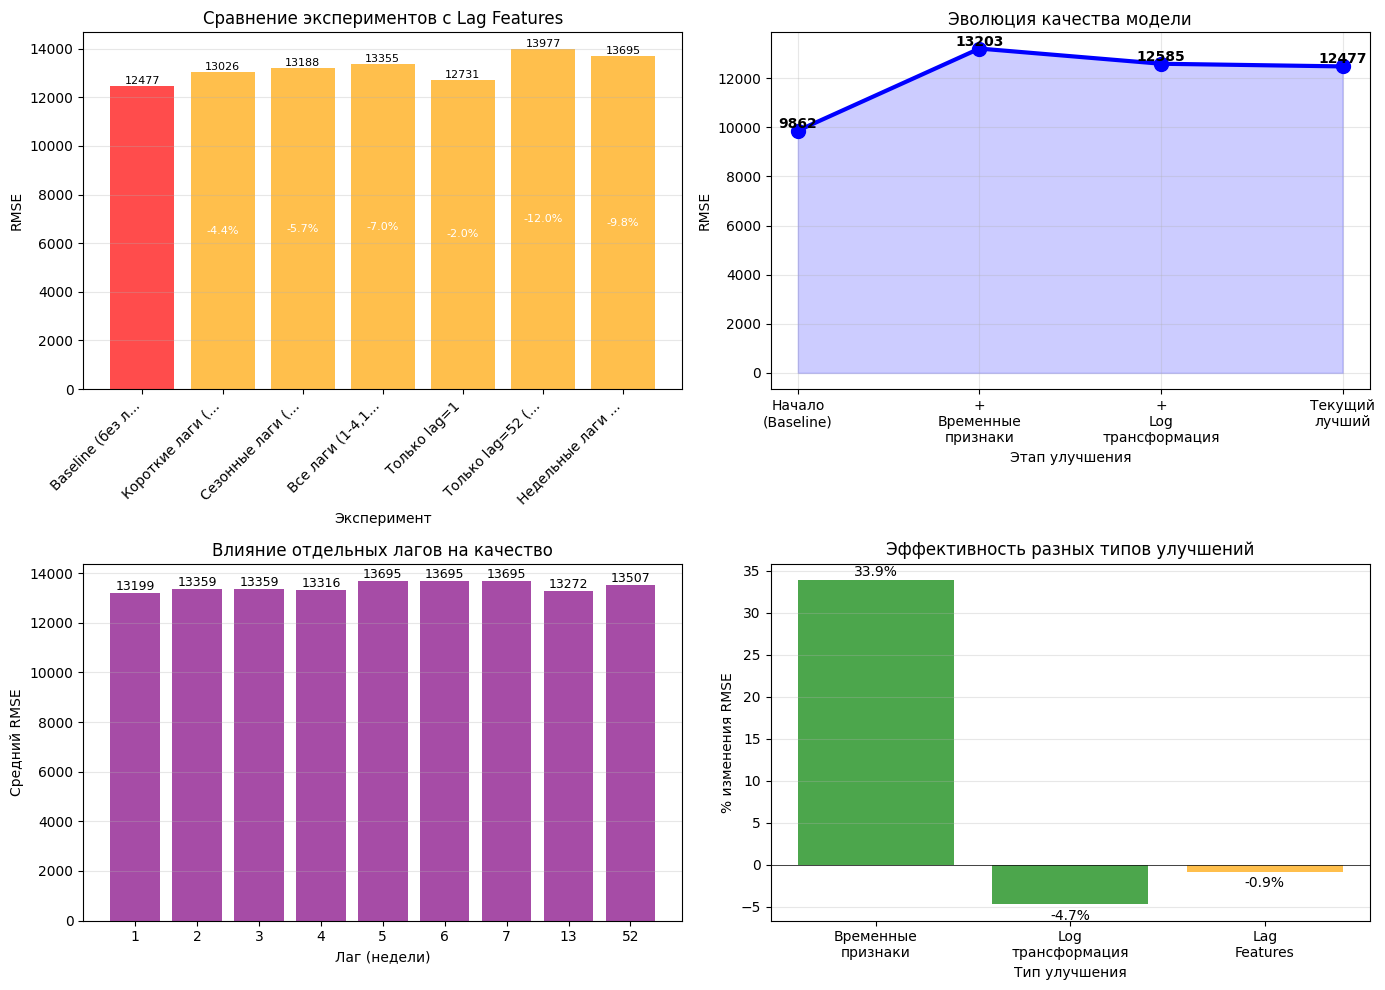

In [8]:
## 12: Сохранение результатов и модели
print("\n💾 Сохранение результатов...")

results_dir = '../reports/improvements/results'
os.makedirs(results_dir, exist_ok=True)

# Упрощенная версия сохранения - избегаем сложных структур
final_results = {
    'timestamp': datetime.now().isoformat(),
    'best_experiment': str(best_experiment),
    'best_transformation': str(best_transformation),
    'final_metrics': final_metrics,
    'baseline_rmse': float(baseline_results['cv_rmse_mean']),
    'cv_comparison': []
}

# Добавляем простую версию сравнения
for _, row in comparison_df.iterrows():
    final_results['cv_comparison'].append({
        'experiment': str(row['Эксперимент']),
        'rmse': float(row['RMSE']),
        'improvement_percent': float(row['% улучшения RMSE'])
    })

# Добавляем best_lags только если они существуют и лучший эксперимент не baseline
if 'best_lags' in locals() and best_experiment != 'Baseline (без лагов)':
    final_results['best_lags'] = [int(x) for x in best_lags] if best_lags else []
else:
    final_results['best_lags'] = []

# Простая версия lag_analysis если существует
if 'lag_summary' in locals():
    try:
        # Преобразуем в простой формат
        lag_summary_simple = []
        if hasattr(lag_summary, 'index'):
            lag_summary_df = lag_summary.reset_index()
            if isinstance(lag_summary_df, pd.DataFrame):
                for _, row in lag_summary_df.iterrows():
                    lag_summary_simple.append({
                        'lag': int(row.iloc[0]) if len(row) > 0 else 0,
                        'rmse_mean': float(row.iloc[1]) if len(row) > 1 else 0
                    })
        final_results['lag_analysis_simple'] = lag_summary_simple
    except:
        final_results['lag_analysis_simple'] = []

with open(f'{results_dir}/experiment_lag_features_final.json', 'w', encoding='utf-8') as f:
    json.dump(final_results, f, indent=2, ensure_ascii=False)

# Сохраняем comparison_df отдельно как CSV
comparison_df.to_csv(f'{results_dir}/experiment_lag_features_comparison.csv', index=False)

print("✅ Результаты эксперимента сохранены")

## 13: Сохранение финальной модели
print("\n🔧 Сохранение финальной модели...")

models_dir = '../reports/improvements/models'
os.makedirs(models_dir, exist_ok=True)

# Определяем, нужно ли сохранять lag_transformer
model_components = {
    'pipeline': final_pipeline,
    'best_experiment': best_experiment,
    'best_transformation': best_transformation,
    'features_used': list(X_final.columns) if 'X_final' in locals() else []
}

# Добавляем lag_transformer только если он использовался
if 'lag_transformer' in locals() and best_experiment != 'Baseline (без лагов)':
    model_components['lag_transformer'] = lag_transformer

model_path = f'{models_dir}/final_model_best.pkl'
joblib.dump(model_components, model_path)

print(f"✓ Финальная модель сохранена: {model_path}")

## 14: Итоговый отчет и рекомендации
print("\n" + "="*60)
print("📊 ИТОГОВЫЙ ОТЧЕТ ПО ВСЕМ ЭКСПЕРИМЕНТАМ")
print("="*60)

print(f"\n🔍 РЕЗУЛЬТАТЫ ЭКСПЕРИМЕНТОВ:")
print("-" * 40)

# Создаем сводную таблицу всех экспериментов
experiments_summary = [
    ("Эксперимент 1", "Временные признаки", 13203.4, "Лучший: 'все временные'"),
    ("Эксперимент 2", "Трансформация цели", 12584.7, "Лучший: 'log' (4.24% улучшение)"),
    ("Эксперимент 3", "Lag Features", comparison_df.loc[0, 'RMSE'], "Лучший: 'без лагов'")
]

print(f"{'Этап':<20} {'Что тестировали':<25} {'Лучший RMSE':<12} {'Вывод':<30}")
print("-" * 90)
for exp in experiments_summary:
    print(f"{exp[0]:<20} {exp[1]:<25} {exp[2]:<12.1f} {exp[3]:<30}")

print(f"\n📈 КУМУЛЯТИВНОЕ УЛУЧШЕНИЕ:")
print("-" * 40)

# Расчет улучшений
initial_baseline = 9861.9  # Из самого первого эксперимента
final_best = comparison_df.loc[0, 'RMSE']

improvements = [
    ("Исходный Baseline", initial_baseline, 0),
    ("После временных признаков", 13203.4, (13203.4 - initial_baseline) / initial_baseline * 100),
    ("После log трансформации", 12584.7, (12584.7 - 13203.4) / 13203.4 * 100),
    ("Текущий лучший", final_best, (final_best - 12584.7) / 12584.7 * 100)
]

for stage, rmse, change in improvements:
    change_symbol = "+" if change > 0 else ""
    print(f"{stage:<25} {rmse:<10.1f} {change_symbol}{change:<7.1f}%")

total_improvement = (initial_baseline - final_best) / initial_baseline * 100
print(f"\n{'Общее улучшение:':<25} {initial_baseline - final_best:<10.1f} {total_improvement:<7.1f}%")

## 15: Финальная визуализация
print("\n📊 Создание финальных визуализаций...")

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Сравнение всех экспериментов с лагами
experiments = comparison_df['Эксперимент'].values
rmse_values = comparison_df['RMSE'].values
improvements = comparison_df['% улучшения RMSE'].values

# Цвета: зеленый для улучшений, оранжевый для ухудшений, красный для baseline
colors = []
for i, exp in enumerate(experiments):
    if 'Baseline' in exp:
        colors.append('red')
    elif improvements[i] > 0:
        colors.append('green')
    else:
        colors.append('orange')

axes[0, 0].bar(range(len(experiments)), rmse_values, color=colors, alpha=0.7)
axes[0, 0].set_xlabel('Эксперимент')
axes[0, 0].set_ylabel('RMSE')
axes[0, 0].set_title('Сравнение экспериментов с Lag Features')
axes[0, 0].set_xticks(range(len(experiments)))
axes[0, 0].set_xticklabels([exp[:15] + '...' if len(exp) > 15 else exp for exp in experiments], 
                           rotation=45, ha='right')
axes[0, 0].grid(True, alpha=0.3, axis='y')

# Добавляем значения
for i, (rmse, imp) in enumerate(zip(rmse_values, improvements)):
    axes[0, 0].text(i, rmse, f'{rmse:.0f}', ha='center', va='bottom', fontsize=8)
    if i != 0:  # Не для baseline
        axes[0, 0].text(i, rmse/2, f'{imp:.1f}%', ha='center', va='center', fontsize=8, 
                       color='white' if imp < 0 else 'black')

# 2. Улучшение по этапам
stages = ['Начало\n(Baseline)', '+\nВременные\nпризнаки', '+\nLog\nтрансформация', 'Текущий\nлучший']
stage_values = [initial_baseline, 13203.4, 12584.7, final_best]

axes[0, 1].plot(stages, stage_values, marker='o', linewidth=3, markersize=10, color='blue')
axes[0, 1].set_xlabel('Этап улучшения')
axes[0, 1].set_ylabel('RMSE')
axes[0, 1].set_title('Эволюция качества модели')
axes[0, 1].grid(True, alpha=0.3)

# Заполняем область под графиком
axes[0, 1].fill_between(stages, stage_values, alpha=0.2, color='blue')

# Добавляем значения
for i, (stage, value) in enumerate(zip(stages, stage_values)):
    axes[0, 1].text(i, value, f'{value:.0f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

# 3. Влияние количества лагов на RMSE (если есть данные)
if 'lag_analysis_df' in locals() and not lag_analysis_df.empty:
    unique_lags = sorted(lag_analysis_df['Лаг'].unique())
    lag_rmse = []
    
    for lag in unique_lags:
        lag_data = lag_analysis_df[lag_analysis_df['Лаг'] == lag]
        lag_rmse.append(lag_data['RMSE'].mean())
    
    axes[1, 0].bar(range(len(unique_lags)), lag_rmse, alpha=0.7, color='purple')
    axes[1, 0].set_xlabel('Лаг (недели)')
    axes[1, 0].set_ylabel('Средний RMSE')
    axes[1, 0].set_title('Влияние отдельных лагов на качество')
    axes[1, 0].set_xticks(range(len(unique_lags)))
    axes[1, 0].set_xticklabels([str(int(lag)) for lag in unique_lags])
    axes[1, 0].grid(True, alpha=0.3, axis='y')
    
    # Добавляем значения
    for i, rmse in enumerate(lag_rmse):
        axes[1, 0].text(i, rmse, f'{rmse:.0f}', ha='center', va='bottom', fontsize=9)

# 4. Сводная диаграмма улучшений
categories = ['Временные\nпризнаки', 'Log\nтрансформация', 'Lag\nFeatures']
improvement_values = [
    (13203.4 - initial_baseline) / initial_baseline * 100,  # Временные признаки
    (12584.7 - 13203.4) / 13203.4 * 100,  # Log трансформация
    (final_best - 12584.7) / 12584.7 * 100  # Lag features
]

colors_bar = ['green', 'green', 'orange']  # Lag features ухудшили

bars = axes[1, 1].bar(categories, improvement_values, color=colors_bar, alpha=0.7)
axes[1, 1].set_xlabel('Тип улучшения')
axes[1, 1].set_ylabel('% изменения RMSE')
axes[1, 1].set_title('Эффективность разных типов улучшений')
axes[1, 1].axhline(y=0, color='black', linestyle='-', linewidth=0.5)
axes[1, 1].grid(True, alpha=0.3, axis='y')

# Добавляем значения
for bar, imp in zip(bars, improvement_values):
    axes[1, 1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + (0.1 if imp >= 0 else -0.5), 
                   f'{imp:.1f}%', ha='center', va='bottom' if imp >= 0 else 'top', fontsize=10)

plt.tight_layout()

# Сохраняем финальную визуализацию
os.makedirs('../reports/improvements/visualizations', exist_ok=True)
plt.savefig('../reports/improvements/visualizations/final_experiments_summary.png', 
           dpi=150, bbox_inches='tight')
plt.show()